In [1]:
# dataframe management
import pandas as pd             

# numerical computation
import numpy as np

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

#---------------------------------------------------------------------------------------------------------
# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()
#----------------------------------------------------------------------------------------------------
from datetime import date
#---------------------------------------------------------------------------------------------------------


Loading BokehJS ...

In [2]:
#reading the notebook
sales = sales_string_date=pd.read_csv('train.csv')

#Removing tuples where stores are closed
sales = sales[sales['IsOpen'] == 1]

In [3]:
sales.describe()

,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,433958.000000,433958.000000,433958.0,433958.000000,433958.000000,433958.000000,433958.000000,433958.000000,433958.000000,433958.000000,...,433958.00000,424700.000000,433958.000000,433958.000000,433958.000000,433958.000000,433958.000000,424700.000000,433958.000000,433958.000000
mean,1373.938579,0.000945,1.0,0.449507,8042.993882,5.727451,312.547433,4890.089953,12313.341916,14045.556837,...,10.33585,12.146459,11.671759,3.799020,51.349308,1012.053362,6.245035,7.251959,0.801154,168.599954
std,216.245290,0.030723,0.0,0.497444,11640.203554,3.357071,158.106619,2215.403562,9114.075588,2760.416990,...,7.04847,5.002097,5.801541,5.871627,19.342648,8.719750,6.312597,4.924885,2.647859,101.207551
min,1000.000000,0.000000,1.0,0.000000,47.000000,0.000000,0.000000,0.000000,344.000000,9893.000000,...,-13.00000,0.000000,2.000000,-18.000000,10.000000,970.000000,-14.000000,0.000000,0.000000,-1.000000
25%,1188.000000,0.000000,1.0,0.000000,1057.000000,3.000000,214.000000,3386.000000,7215.000000,11849.000000,...,4.00000,10.000000,8.000000,-1.000000,36.000000,1007.000000,1.000000,3.000000,0.000000,74.000000
50%,1373.000000,0.000000,1.0,0.000000,3307.000000,6.000000,278.000000,4469.500000,9337.000000,15017.000000,...,11.00000,11.000000,11.000000,4.000000,51.000000,1012.000000,7.000000,8.000000,0.000000,188.000000
75%,1561.000000,0.000000,1.0,1.000000,9761.000000,9.000000,369.000000,5911.000000,15566.000000,15931.000000,...,16.00000,14.000000,14.000000,8.000000,66.000000,1018.000000,11.000000,10.000000,0.250000,248.000000
max,1748.000000,1.000000,1.0,1.000000,85070.000000,10.000000,2206.000000,26641.000000,32221.000000,23931.000000,...,30.00000,31.000000,53.000000,18.000000,100.000000,1038.000000,24.000000,31.000000,58.930000,360.000000


# Imputation of Missing Values

In [4]:
unknown_per_columns = sales.isnull().sum()
unknown_per_columns

StoreID                            0
Date                               0
IsHoliday                          0
IsOpen                             0
HasPromotions                      0
StoreType                          0
AssortmentType                     0
NearestCompetitor                  0
Region                             0
NumberOfCustomers                  0
NumberOfSales                      0
Region_AreaKM2                     0
Region_GDP                         0
Region_PopulationK                 0
CloudCover                     34057
Events                        103661
Max_Dew_PointC                     0
Max_Gust_SpeedKm_h            341404
Max_Humidity                       0
Max_Sea_Level_PressurehPa          0
Max_TemperatureC                   0
Max_VisibilityKm                9258
Max_Wind_SpeedKm_h                 0
Mean_Dew_PointC                    0
Mean_Humidity                      0
Mean_Sea_Level_PressurehPa         0
Mean_TemperatureC                  0
M

We see that Max_Gust_SpeedKm_h has 409947 missing values. We decided not to impute it.
Let's start with imputation of "Events"

In [5]:
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_missing.describe()


,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,103661.000000,103661.000000,103661.0,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,...,103661.000000,94779.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,94779.000000,103661.000000,103661.000000
mean,1371.071907,0.001042,1.0,0.459179,8601.390619,5.719142,314.641910,4893.577276,11435.271770,13711.770926,...,11.545769,15.176421,11.082558,3.092774,40.196747,1015.171096,6.551538,10.586121,0.003920,134.812292
std,215.337540,0.032261,0.0,0.498333,12222.596970,3.319136,159.283348,2238.517426,8284.862826,2736.202628,...,7.492758,6.648346,5.112519,6.093297,18.033663,7.151478,6.591203,6.138289,0.087722,103.812782
min,1000.000000,0.000000,1.0,0.000000,47.000000,0.000000,0.000000,0.000000,344.000000,9893.000000,...,-11.000000,2.000000,3.000000,-17.000000,10.000000,991.000000,-12.000000,0.000000,0.000000,-1.000000
25%,1187.000000,0.000000,1.0,0.000000,1116.000000,3.000000,215.000000,3375.000000,7215.000000,11849.000000,...,6.000000,10.000000,6.000000,-2.000000,25.000000,1011.000000,1.000000,8.000000,0.000000,46.000000
50%,1369.000000,0.000000,1.0,0.000000,3614.000000,6.000000,280.000000,4461.000000,9337.000000,13155.000000,...,12.000000,13.000000,10.000000,3.000000,37.000000,1015.000000,7.000000,10.000000,0.000000,124.000000
75%,1553.000000,0.000000,1.0,1.000000,10593.000000,9.000000,372.000000,5918.000000,15566.000000,15931.000000,...,18.000000,19.000000,13.000000,8.000000,52.000000,1020.000000,12.000000,10.000000,0.000000,216.000000
max,1748.000000,1.000000,1.0,1.000000,85070.000000,10.000000,2206.000000,26641.000000,32221.000000,23931.000000,...,30.000000,31.000000,34.000000,18.000000,100.000000,1038.000000,23.000000,31.000000,4.060000,360.000000


In [6]:
sales['Events'].value_counts()

Rain                           171189
Fog                             56323
Fog-Rain                        41804
Rain-Thunderstorm               18116
Rain-Snow                       14576
Snow                            12541
Fog-Rain-Thunderstorm            6545
Fog-Snow                         2469
Fog-Rain-Snow                    2364
Thunderstorm                     1298
Rain-Hail                        1148
Rain-Snow-Hail                    513
Fog-Rain-Snow-Hail                231
Rain-Snow-Hail-Thunderstorm       193
Fog-Rain-Hail-Thunderstorm        178
Fog-Snow-Hail                     169
Fog-Rain-Hail                     168
Fog-Thunderstorm                  157
Snow-Hail                         134
Rain-Snow-Thunderstorm            131
Rain-Hail-Thunderstorm             50
Name: Events, dtype: int64

By this, we discover that when Event is null the weather is good, from the fact that Precipitationmm mean is almost 0.
Furthermore, all the labels of Events are related to bad weather, that means that when no precipitation occurs the label is null.
We will impute Event by replacing the missing values with "Not Specified" (later).

Now we impute "CloudCover", making a distinction when it misses along with Events and when it misses on its own.

In [7]:
null_Events = sales['Events'].isnull()
null_CloudCover = sales['CloudCover'].isnull()
cloudcover_missing = sales[(null_Events)]
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_cc_missing = sales[null_CloudCover & null_Events]
cloudcover_missing.shape, event_missing.shape, event_cc_missing.shape 


((103661, 36), (103661, 36), (23264, 36))

There are 28k tuples where both "Events" and "CloudCover" are missing, that means that the weather should be good.
for the remaining (41k-28k) (i.e. where "Events" is not null!) tuples we impute the CloudCoverage.

In [8]:
event_notmissing_cc_missing = sales[null_CloudCover & ~null_Events]
#computing mean where CloudCover is not null
mean_CC = sales["CloudCover"].mean()
event_notmissing_cc_missing["CloudCover"] = event_notmissing_cc_missing["CloudCover"].fillna(mean_CC)
sales = pd.concat([sales[~null_CloudCover | null_Events], event_notmissing_cc_missing])

Then, we impute the remaining rows with CloudCover missing

In [9]:
null_Events = sales['Events'].isnull()
CloudyButNotEvent = sales[null_Events]
#there are some tuples with no Events but with the attribute CloudCover

In [10]:
null_cloudCover = sales[sales['CloudCover'].isnull()]
mean_cloudCover = sales["CloudCover"].mean()
null_cloudCover["CloudCover"] = null_cloudCover["CloudCover"].fillna(mean_cloudCover)

sales = pd.concat([sales[~sales['CloudCover'].isnull()], null_cloudCover])

Now, we impute min,max,mean_VisibilityKm. 

In [11]:
# checking if are all the same rows where visibility data are missing => yes, they are
sales[["Max_VisibilityKm", "Mean_VisibilityKm", "Min_VisibilitykM"]].count()

Max_VisibilityKm     424700
Mean_VisibilityKm    424700
Min_VisibilitykM     424700
dtype: int64

In [12]:
null_visibility = sales[sales['Max_VisibilityKm'].isnull()]
mean_vis_max = sales["Max_VisibilityKm"].mean()
mean_vis_mean = sales["Mean_VisibilityKm"].mean()
mean_vis_min = sales["Min_VisibilitykM"].mean()

null_visibility["Max_VisibilityKm"] = null_visibility["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibility["Mean_VisibilityKm"] = null_visibility["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibility["Min_VisibilitykM"] = null_visibility["Min_VisibilitykM"].fillna(mean_vis_min)

sales = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])

Finally, we impute "Events".

In [13]:
sales=sales.replace(np.nan,'NotSpecified', regex=True)


# Dealing with outliers

In [14]:
'''#Winsorizing of  NearestCompetitor on 95th percentile
#Before
avgSalesForCompDist=sales
avgSalesForCompDist.groupby('NearestCompetitor', as_index=False)['NumberOfSales'].mean()
x = avgSalesForCompDist['NearestCompetitor']
y = avgSalesForCompDist['NumberOfSales']
font = {'family' : 'sans', 'size'   : 16}
plt.figure(figsize=(20,10))
plt.rc('font', **font)
#plt.ylim((1.75,7.25))
#plt.xlim((10,80))
plt.xlabel("NearestCompetitor")
plt.ylabel("Average NumberOfSales")
plt.scatter(x, y, color='blue', marker='o', s=5)
plt.grid()'''

'#Winsorizing of  NearestCompetitor on 95th percentile\n#Before\navgSalesForCompDist=sales\navgSalesForCompDist.groupby(\'NearestCompetitor\', as_index=False)[\'NumberOfSales\'].mean()\nx = avgSalesForCompDist[\'NearestCompetitor\']\ny = avgSalesForCompDist[\'NumberOfSales\']\nfont = {\'family\' : \'sans\', \'size\'   : 16}\nplt.figure(figsize=(20,10))\nplt.rc(\'font\', **font)\n#plt.ylim((1.75,7.25))\n#plt.xlim((10,80))\nplt.xlabel("NearestCompetitor")\nplt.ylabel("Average NumberOfSales")\nplt.scatter(x, y, color=\'blue\', marker=\'o\', s=5)\nplt.grid()'

In [15]:
#index1=np.where(sales['NearestCompetitor']>=NC95p)
#sales['NearestCompetitor'][index1]

NC95p=sales['NearestCompetitor'].quantile(.95)
sales.loc[sales["NearestCompetitor"]>NC95p,"NearestCompetitor"]=NC95p

In [16]:
'''#Winsorizing of Precipitationmm on 95th percentile
#Before
avgSalesForCompDist=sales
avgSalesForCompDist.groupby('Precipitationmm', as_index=False)['NumberOfSales'].mean()
x = avgSalesForCompDist['Precipitationmm']
y = avgSalesForCompDist['NumberOfSales']
font = {'family' : 'sans', 'size'   : 16}
plt.figure(figsize=(20,10))
plt.rc('font', **font)
#plt.ylim((1.75,7.25))
#plt.xlim((10,80))
plt.xlabel("Precipitationmm")
plt.ylabel("Average NumberOfSales")
plt.scatter(x, y, color='blue', marker='o', s=5)
plt.grid()'''

'#Winsorizing of Precipitationmm on 95th percentile\n#Before\navgSalesForCompDist=sales\navgSalesForCompDist.groupby(\'Precipitationmm\', as_index=False)[\'NumberOfSales\'].mean()\nx = avgSalesForCompDist[\'Precipitationmm\']\ny = avgSalesForCompDist[\'NumberOfSales\']\nfont = {\'family\' : \'sans\', \'size\'   : 16}\nplt.figure(figsize=(20,10))\nplt.rc(\'font\', **font)\n#plt.ylim((1.75,7.25))\n#plt.xlim((10,80))\nplt.xlabel("Precipitationmm")\nplt.ylabel("Average NumberOfSales")\nplt.scatter(x, y, color=\'blue\', marker=\'o\', s=5)\nplt.grid()'

In [17]:
temp=sales['Precipitationmm'].quantile(.99)
sales.loc[sales["Precipitationmm"]>temp,"Precipitationmm"]=temp
temp

11.94

In [18]:
'''#After
avgSalesForCompDist=sales
avgSalesForCompDist.groupby('Precipitationmm', as_index=False)['NumberOfSales'].mean()
x = avgSalesForCompDist['Precipitationmm']
y = avgSalesForCompDist['NumberOfSales']
font = {'family' : 'sans', 'size'   : 16}
plt.figure(figsize=(20,10))
plt.rc('font', **font)
#plt.ylim((1.75,7.25))
#plt.xlim((10,80))
plt.xlabel("Precipitationmm")
plt.ylabel("Average NumberOfSales")
plt.scatter(x, y, color='blue', marker='o', s=5)
plt.grid()'''

'#After\navgSalesForCompDist=sales\navgSalesForCompDist.groupby(\'Precipitationmm\', as_index=False)[\'NumberOfSales\'].mean()\nx = avgSalesForCompDist[\'Precipitationmm\']\ny = avgSalesForCompDist[\'NumberOfSales\']\nfont = {\'family\' : \'sans\', \'size\'   : 16}\nplt.figure(figsize=(20,10))\nplt.rc(\'font\', **font)\n#plt.ylim((1.75,7.25))\n#plt.xlim((10,80))\nplt.xlabel("Precipitationmm")\nplt.ylabel("Average NumberOfSales")\nplt.scatter(x, y, color=\'blue\', marker=\'o\', s=5)\nplt.grid()'

In [19]:
temp=sales['Max_Wind_SpeedKm_h'].quantile(.99)
sales.loc[sales["Max_Wind_SpeedKm_h"]>temp,"Max_Wind_SpeedKm_h"]=temp
temp

50.0

In [20]:
temp=sales['Max_Wind_SpeedKm_h'].quantile(.01)
sales.loc[sales["Max_Wind_SpeedKm_h"]<temp,"Max_Wind_SpeedKm_h"]=temp
temp

8.0

In [21]:
temp=sales['Max_TemperatureC'].quantile(.99)
sales.loc[sales["Max_TemperatureC"]>temp,"Max_TemperatureC"]=temp
temp

32.0

In [22]:
temp=sales['Max_TemperatureC'].quantile(.01)
sales.loc[sales["Max_TemperatureC"]<temp,"Max_TemperatureC"]=temp
temp

-2.0

In [23]:
x='Min_TemperatureC'
temp=sales[x].quantile(.01)
sales.loc[sales[x]<temp,x]=temp
temp=sales[x].quantile(.99)
sales.loc[sales[x]>temp,x]=temp

In [24]:
x='Mean_Dew_PointC'
temp=sales[x].quantile(.05)
sales.loc[sales[x]<temp,x]=temp
temp=sales[x].quantile(.98)
sales.loc[sales[x]>temp,x]=temp

In [25]:
x='Mean_Humidity'
temp=sales[x].quantile(.01)
sales.loc[sales[x]<temp,x]=temp
temp=sales[x].quantile(.95)
sales.loc[sales[x]>temp,x]=temp

In [26]:
x='Min_VisibilitykM'
temp=sales[x].quantile(.98)
sales.loc[sales[x]>temp,x]=temp

In [27]:
x='Min_Humidity'
temp=sales[x].quantile(.02)
sales.loc[sales[x]<temp,x]=temp
temp=sales[x].quantile(.98)
sales.loc[sales[x]>temp,x]=temp

In [28]:
x='Mean_Wind_SpeedKm_h'
temp=sales[x].quantile(.99)
sales.loc[sales[x]>temp,x]=temp

In [29]:
x='Mean_TemperatureC'
temp=sales[x].quantile(.01)
sales.loc[sales[x]<temp,x]=temp
temp=sales[x].quantile(.99)
sales.loc[sales[x]>temp,x]=temp

In [30]:
x='Mean_VisibilityKm'
temp=sales[x].quantile(.01)
sales.loc[sales[x]<temp,x]=temp
temp=sales[x].quantile(.95)
sales.loc[sales[x]>temp,x]=temp

In [31]:
#Min_Sea_Level_PressurehPa  ->dropparla
#WindDirDegrees             -> inutile secondo me -> o la si categorizza in nord sud est ovest e la si fa con One Hot Encoding
#x=""
#sales[x].describe()
#sales[x].quantile(.01)
#sales[x].quantile(.95)

# Normalization of Numerical Variables

In [32]:
from scipy.stats import skew

# take the numerical features
numeric_feats = sales.dtypes[sales.dtypes != "object"].index

# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = sales[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.data})
# select the variables with a skewness above a certain threshold

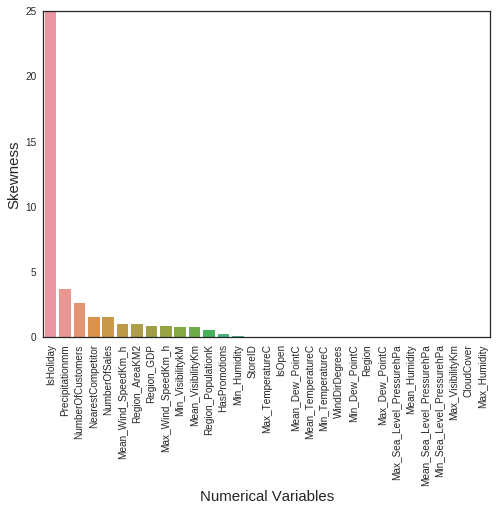

In [33]:
skewness = skewness.sort_values('Skewness', ascending=[0])

f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [34]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.drop(['IsHoliday','NumberOfCustomers'])
sales[skewed_feats.index] = np.log1p(sales[skewed_feats.index])

# Correlation Analysis and Feature Selection

In [35]:
'''categorical_variables_mask = (sales.dtypes==object) | (sales.columns == "Day") | (sales.columns == "Month") | (sales.columns == "Year") | (sales.columns == "StoreID") | (sales.columns == "IsOpen") | (sales.columns == "IsHoliday") | (sales.columns == "HasPromotions") | (sales.columns == "Region"  )
categorical_variables = categorical_variables_mask.tolist()
numerical_variables = sales.columns[~categorical_variables_mask]
cov=sales[numerical_variables].corr(method='pearson')
cm = sns.clustermap(cov, annot=True, center=0, cmap="Blues", figsize=(25, 25))
cm.cax.set_visible(False)'''

'categorical_variables_mask = (sales.dtypes==object) | (sales.columns == "Day") | (sales.columns == "Month") | (sales.columns == "Year") | (sales.columns == "StoreID") | (sales.columns == "IsOpen") | (sales.columns == "IsHoliday") | (sales.columns == "HasPromotions") | (sales.columns == "Region"  )\ncategorical_variables = categorical_variables_mask.tolist()\nnumerical_variables = sales.columns[~categorical_variables_mask]\ncov=sales[numerical_variables].corr(method=\'pearson\')\ncm = sns.clustermap(cov, annot=True, center=0, cmap="Blues", figsize=(25, 25))\ncm.cax.set_visible(False)'

By analyzing the correlation, we see that the following variables do not add any additional information. 
Max_Dew_PointC, Min_Dew_PointC, Max_Sea_Level_PressurehPa, Mean_Sea_Level_PressurehPa, Max_Gust_SpeedKm_h
Finally, we drop 'NumberOfCustomers' because is not present in the submission dataset.

In [36]:
sales=sales.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h'])
sales.shape

(433958, 31)

Drop of the row where IsOpen==0

In [37]:
sales=sales[sales['IsOpen']==1]
sales=sales.drop(columns=['IsOpen'])
sales['StoreID'] = sales['StoreID'].astype(object)

Separating the last 2 months, and use those as a test set and comparing the total of the predicted values.

In [38]:
def AddMonthYearColumn(d):
    d["MonthYear"] = d[["Date"]].applymap(lambda x : "/".join(x.split("/")[1:])) # get the month
    return d

# return only the data in the months and years specified, passed as a list (e.g. ["01/2017","02/2017"])
def FilterMonthsYears(data, monthsYears):
    d = AddMonthYearColumn(data)
    mask =(d.columns=="MonthYear")
    d = d[d["MonthYear"].isin(monthsYears)]
    return d[d.columns[~mask]]

# return all the data except the ones in the months and years specified, passed as a list (e.g. ["01/2017","02/2017"])
def NegativeFilterMonthsYears(data, monthsYears):
    d = AddMonthYearColumn(data)
    mask =(d.columns=="MonthYear")
    d = d[~d["MonthYear"].isin(monthsYears)]
    return d[d.columns[~mask]]

In [39]:
sales = pd.get_dummies(sales, columns=['StoreType','Events','AssortmentType'])

In [40]:
months_test = ["01/2017","02/2017","01/2018","02/2018"]
train = NegativeFilterMonthsYears(sales,months_test)
test = FilterMonthsYears(sales,months_test)

In [41]:
import datetime as d
def toDate(x):
    parts = [int(el) for el in x.split("/")]
    return d.date(parts[2], parts[1], parts[0])
#sales["Date"] = sales["Date"].apply(toDate)
#sales['Date'] = sales['Date'].astype("datetime64")
#sales['Day_Of_Week'] = sales['Date'].dt.weekday_name
#sales=sales.drop(columns=['Date'])

train["Date"] = train["Date"].apply(toDate)
train['Date'] = train['Date'].astype("datetime64")
train['Day_Of_Week'] = train['Date'].dt.weekday_name
train=train.drop(columns=['Date'])

test["Date"] = test["Date"].apply(toDate)
test['Date'] = test['Date'].astype("datetime64")
test['Day_Of_Week'] = test['Date'].dt.weekday_name
test=test.drop(columns=['Date'])


# One Hot Encoding of train and set

In [42]:
train = pd.get_dummies(train, columns=['Day_Of_Week'])
test = pd.get_dummies(test, columns=['Day_Of_Week'])


# First try: MultipleLinear Regression for Region 3

We start by predicting the number of customers for Region 3

In [43]:
train_region3= train.loc[train['Region'] == 3]
test_region3= test.loc[test['Region'] == 3] 
train_region3.shape , test_region3.shape

((46912, 62), (9190, 62))

# STEP 1 : PREDICT THE NUMBER OF CUSTOMERS

In [44]:
train_x_region3_step1 = train_region3.drop(columns=['NumberOfSales','NumberOfCustomers'])
train_y_region3_step1 = pd.DataFrame(data = train_region3['NumberOfCustomers'])

test_x_region3_step1 = test_region3.drop(columns=['NumberOfSales','NumberOfCustomers'])
test_y_region3_step1 = pd.DataFrame(data = test_region3['NumberOfCustomers']) 

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def r2_cv(model, sales_train, y, random_state=12345678):
    r2= cross_val_score(model, sales_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state)) 
    return(r2)

def rmse_cv(model, sales_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, sales_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

In [46]:
model_simple = LinearRegression()
model_simple.fit(train_x_region3_step1, train_y_region3_step1)
yp = model_simple.predict(test_x_region3_step1) #yp=predicted customers del test

# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(test_y_region3_step1,yp)
r2_xval_simple =  r2_cv(model_simple, test_x_region3_step1, test_y_region3_step1)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(test_y_region3_step1,yp,multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, test_x_region3_step1,test_y_region3_step1)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))

Linear Regression
	                  Train R2=0.160
	10-fold Crossvalidation R2=0.214
	                  Train RMSE=26741.814
	10-fold Crossvalidation RMSE=158.097


# STEP 2 : PREDICT THE NUMBER OF SALES

In [47]:
training_fed = NegativeFilterMonthsYears(sales, months_test)


train_x_step2 = training_fed.drop(columns=['NumberOfSales'])
train_y_step2 = pd.DataFrame(data = training_fed['NumberOfSales'])


test_x_region3_step2 = test_region3.drop(columns=['NumberOfSales','NumberOfCustomers'])
test_x_region3_step2['NumberOfCustomers']= yp

test_y_region3_step2 = pd.DataFrame(data = test_region3['NumberOfSales']) 

We keep only the most correlated features with the sales.

In [48]:
train_x_step2 = train_x_step2[['NumberOfCustomers','Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP']]
test_x_region3_step2 = test_x_region3_step2[['NumberOfCustomers','Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP']]

In [49]:
model_simple_step2 = LinearRegression()
model_simple_step2.fit(train_x_step2, train_y_step2)
yp2 = model_simple_step2.predict(test_x_region3_step2) #yp2= le sales predette alla fine

Thumb-metric: compare the error over the sum of sales.

In [50]:
np.abs((test_y_region3_step2.sum() - np.sum(yp2))/test_y_region3_step2.sum())

NumberOfSales    0.004599
dtype: float64

In [51]:
test_y_region3_step2.sum(),np.sum(yp2)

(NumberOfSales    78427.431109
 dtype: float64, 78788.09080881265)

In [52]:
# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(test_y_region3_step2,yp2)
r2_xval_simple =  r2_cv(model_simple, test_x_region3_step2, test_y_region3_step2)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(test_y_region3_step2, yp2, multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, test_x_region3_step2, test_y_region3_step2)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))

Linear Regression
	                  Train R2=0.132
	10-fold Crossvalidation R2=0.167
	                  Train RMSE=0.168
	10-fold Crossvalidation RMSE=0.402


In [55]:
def RegionError(region, data):
    d = data[data["Region"] == region][["NumberOfActualSales", "NumberOfSales"]]
    res = abs(d["NumberOfActualSales"]-d["NumberOfSales"]).agg("sum")
    return res / d["NumberOfActualSales"].agg("sum")
check = pd.DataFrame(test_y_region3_step2)
check["Region"] = 3
check["NumberOfActualSales"] = test_y_region3_step2[["NumberOfSales"]]
check["NumberOfSales"] = yp2
RegionError(3, check)

0.038183253926218116